# 가제 : 합성데이터를 활용한 유방암 수술 후 치료 유형별 생존 분석: 조직학적 아형을 고려한 인과추론 및 Uplift 모델링 접근

# 1. 데이터 읽기

In [1]:
# 성능이 주 목적인 머신러닝 구축환경이 아니기에 train과 test를 하나의 데이터로 합침

import pandas as pd

path = 'data/'
synbreast_trainset = pd.read_excel(path + 'Adjusted_synbreast_trainset.xlsx')
synbreast_testset = pd.read_excel(path + 'Adjusted_synbreast_test.xlsx')

df = pd.concat([synbreast_trainset,synbreast_testset], axis=0)
df

,No,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,T1,T1mi,T1a,...,PR,AR,BCS,Mestectomy,pan hysterosalpingo oophorectomy,Chemotherapy,Hormone therapy,Radiation Therapy,Death,Survival period
0,0,33,0,1,0,0,1,1,0,0,...,2,9,1,99,0,1,0,1,0,472
1,1,72,0,1,1,1,0,0,0,1,...,1,99,1,0,0,0,1,1,0,835
2,2,41,0,0,0,0,0,0,0,1,...,99,9,99,1,0,1,1,0,1,1136
3,3,61,1,0,0,1,0,1,0,0,...,1,99,99,0,0,0,1,1,1,145
4,4,44,0,1,0,0,0,0,1,0,...,2,99,0,99,0,0,1,1,1,906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,56,0,1,0,1,1,0,1,0,...,1,99,1,0,0,1,1,1,0,145
4996,4996,65,0,0,1,0,1,0,1,0,...,1,2,1,0,0,1,1,1,1,1360
4997,4997,44,0,1,0,0,1,1,0,0,...,1,9,1,0,1,1,0,1,0,67
4998,4998,58,0,1,0,1,1,0,0,0,...,2,9,1,99,1,0,1,0,0,133


<Axes: >

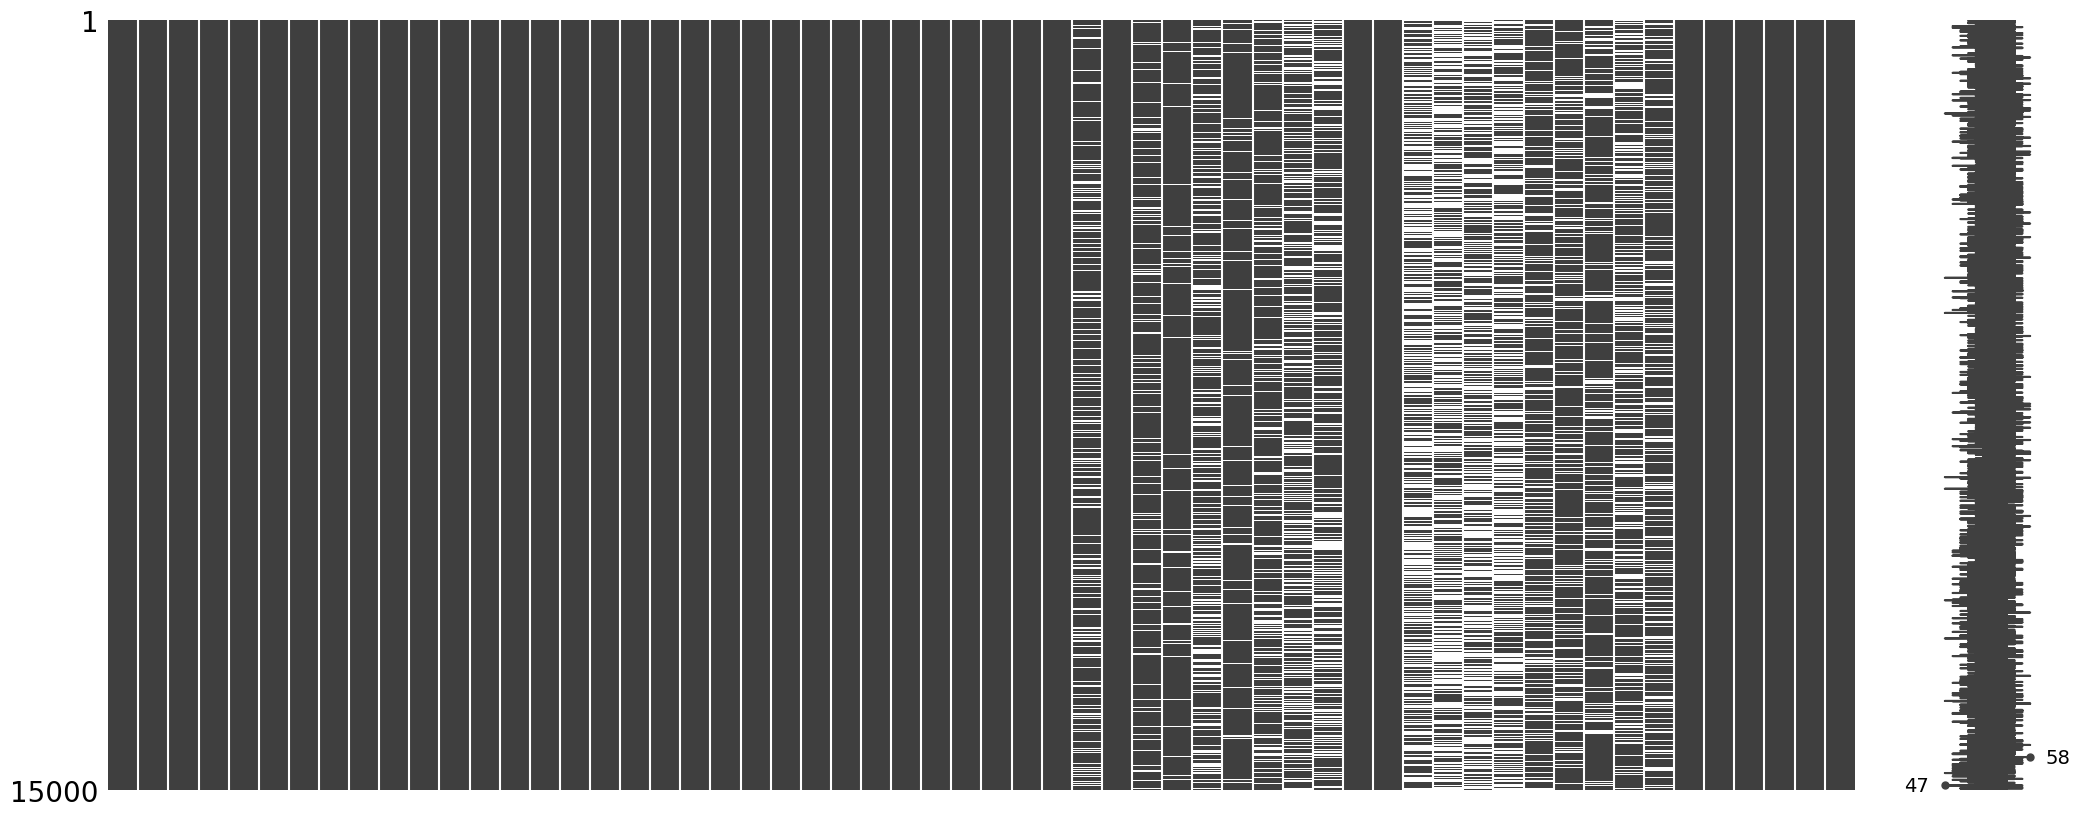

In [2]:
import missingno as msno
import numpy as np

# 결측치는 X
# 다만 99라는 값은 다수의 컬럼에서 결측치를 대신 함
msno.matrix(df.replace(99, np.nan))

In [3]:
df.Death.value_counts()

Death
0    9697
1    5303
Name: count, dtype: int64

# 2. 변수 설명

In [4]:
a = {
  'AGE': '진단시연령',  # 진단 당시 연령 (예: 45세)
  'inductal carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '관상피암'으로, 유방의 관에서 시작되는 암)
  'infiltrating duct carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '침윤성 관암'으로, 유방의 관에서 시작되어 주변 조직으로 침윤하는 암)
  'adenocarcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '선암'으로, 유방의 샘 조직에서 발생하는 암)
  'lobular carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '소엽암'으로, 유방의 소엽에서 시작되는 암)
  'Metaplastic carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '화생암'으로, 유방암 세포가 다른 조직 형태로 변형된 암)
  'TX': '병기STAGE', # 존재 안함
  'T0': '병기STAGE', # 존재 안함
  'T1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 종양 크기 및 침습 정도에 따라 T1 단계로 분류)
  'T1mi': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 미세 침습성 암으로 T1의 하위 분류)
  'T1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T1 중 0.1~0.5cm 크기의 종양)
  'T1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T1 중 0.5~1cm 크기의 종양)
  'T1c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 이미지에서 T1c는 0=아니오, 1=예로 나타남, T1 중 1~2cm 크기의 종양)
  'T2': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 2~5cm 크기의 종양)
  'T2a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T2 중 2~3cm 크기의 종양)
  'T2b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T2 중 3~5cm 크기의 종양)
  'T3': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 5cm 이상의 종양 또는 인접 구조 침범)
  'T4': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 종양이 피부나 흉벽으로 침범된 경우)
  'Nx': '병기STAGE', # 존재 안함
  'N1mi': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 림프절 미세 전이)
  'N1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 1~3개 림프절 전이)
  'N1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 이동성 림프절 전이)
  'N1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 내부 유방 림프절 전이)
  'N1c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 피부나 근육 내 전이)
  'N2': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 4~9개 림프절 전이)
  'N2a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N2 중 이동성 림프절 4~9개 전이)
  'N2b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N2 중 흉곽 내 또는 상완 림프절 전이)
  'N3': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 10개 이상 림프절 전이)
  'N3a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 10개 이상 흉곽 아래 림프절 전이)
  'N3b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 흉곽 내 또는 유방 위 림프절 전이)
  'N3c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 쇄골 위 림프절 전이)
  'M1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 원격 전이 존재)
  'M1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, M1 중 단일 원격 전이)
  'M1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, M1 중 다발성 원격 전이)
  'Type of Drink': '음주종류',  # 음주 종류 (예: 0=맥주,1=소주, 2=양주, 99=기타)
  'Smoke': '흡연여부',  # 흡연 여부 (예: 0=비흡연, 1=흡연, 2=과거 흡연)
  'Age of Menarch': '초경연령',  # 초경 연령 (예: 16, 99=모름)
  'Age of Menopause': '폐경연령',  # 폐경 연령 (예: 55, 99=모름)
  'Marriage': '결혼여부',  # 결혼 여부 (예: 0=아니오, 1=예, 99=모름)
  'Age at first birth': '첫출산연령',  # 첫 출산 연령 (예: 20, 99=해당사항 없음)
  'Number of births': '출산자녀수',  # 출산 자녀 수 (예: 3, 99=해당사항 없음)
  'COCP': '경구피임약사용여부',  # 경구 피임약 사용 여부 (예: 0=아니오, 1=예, 99=모름)
  'HRT': 'HRT 사용여부',  # 호르몬 대체 요법(HRT) 사용 여부 (예: 0=아니오, 1=예, 99=모름)
  'Height': '신장값',  # 신장 값 (예: 158cm)
  'Weight': '체중측정값',  # 체중 값 (예: 58kg)
  'BRCA1 PVs': 'BRCA1 병원변형체 검출 여부',  # BRCA1 병원변형체 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA1 VUS': 'BRCA1 미확인변이 검출 여부',  # BRCA1 미확인변이 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA2 PVs': 'BRCA2 병원변형체 검출 여부',  # BRCA2 병원변형체 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA2 VUS': 'BRCA2 미확인변이 검출 여부',  # BRCA2 미확인변이 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'ER': '면역병리ER검사결과코드',  # Estrogen Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'PR': '면역병리PR검사결과코드',  # Progesterone Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'AR': '면역병리AR검사결과코드',  # Androgen Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BCS': '유방보전적절제술여부 BCS',  # 유방보전적절제술 여부 (예: 0=아니오, 1=예, 99=해당사항 없음)
  'Mestectomy': '유방전절제술여부',  # 유방 전절제술 여부 (예: 0=아니오, 1=예, 99=해당사항 없음)
  'pan hysterosalpingo oophorectomy': '양측난관난소절제술여부',  # 양측 난관 난소 절제술 여부 (예: 0=아니오, 1=예)
  'Chemotherapy': '항암치료여부',  # 항암치료 여부 (예: 0=아니오, 1=예)
  'Hormone therapy': '호르몬치료여부',  # 호르몬치료 여부 (예: 0=아니오, 1=예)
  'Radiation Therapy': '방사선치료여부',  # 방사선치료 여부 (예: 0=아니오, 1=예)
  'Death': '사망여부',  # 사망 여부 (예: 0=아니오, 1=예)
  'Survival period': '암진단후생존일수',  # 암 진단 후 생존 일수 (예: 267일)
}
len(a)

60

In [5]:
# 99가 있는 컬럼만 뽑음
# 99 값이 어느정도 있는지
for i in [ 'Type of Drink', 'Marriage',
       'COCP', 'HRT', 'BRCA1 PVs',
       'BRCA1 VUS', 'BRCA2 PVs', 'BRCA2 VUS', 'ER', 'PR', 'AR', 'BCS',
       'Mestectomy','Age of Menarch','Age of Menopause']:
    print(df[i].value_counts(),'\n')

Type of Drink
0     5952
1     3293
2     3207
99    2548
Name: count, dtype: int64 

Marriage
1     7677
99    4127
0     3196
Name: count, dtype: int64 

COCP
0     6900
99    4788
1     3312
Name: count, dtype: int64 

HRT
0     6855
99    4666
1     3479
Name: count, dtype: int64 

BRCA1 PVs
99    8103
2     3847
1     3050
Name: count, dtype: int64 

BRCA1 VUS
99    7542
2     3960
1     3498
Name: count, dtype: int64 

BRCA2 PVs
99    7549
2     4296
1     3155
Name: count, dtype: int64 

BRCA2 VUS
99    7230
2     4153
1     3617
Name: count, dtype: int64 

ER
1     7536
2     4340
99    3124
Name: count, dtype: int64 

PR
1     6663
2     5383
99    2954
Name: count, dtype: int64 

AR
9     5674
1     4179
2     2693
99    2454
Name: count, dtype: int64 

BCS
1     6962
99    4643
0     3395
Name: count, dtype: int64 

Mestectomy
0     7709
1     3661
99    3630
Name: count, dtype: int64 

Age of Menarch
99    1581
15    1465
16    1416
13    1407
14    1373
17    1181
12    11

# 3. 일부 데이터 전처리
- 조직학적 진단 묶기(폐기)
- ER, PR 즉 수용체 조합 변수 생성
- 초경과 폐경을 활용한 월경 기간 및 현재상황유무의 변수 두개 생성
- 키와 몸무게 활용한 BMI
- 흡연 여부 범주 단순화
- 병기 스테이지 범주화

In [6]:
# BRCA VUS는 미확인 변이로서, 이는 아직 임상학적으로 유방암과 관련이 있는지 모르기에 제외(결측치도 다수 존재하기에)
# Type of Drink는 음주여부가 아닌 음주종류이기에 제외(99가 결측치가 아닌 기타이기에 다소 모호함)
# 면역병리에서 ER, PR과 더불어 AR도 최근 중요하다는 글들이 많지만, AR 변수 값 설명에서 9, 99 = 해당사항 없음이 다소 많으며, 왜 두 개(9,99)로 분류되어있는 지 해석 불가

In [7]:
# 조직학적 진단명 5가지 변수
# 희소한 진단 없고, 중복 진단 가능
# 어떻게 해야할지를 모르겠음
['inductal carcinoma', 'infiltrating duct carcinoma','adenocarcinoma', 'lobular carcinoma', 'Metaplastic carcinoma']

from sklearn.preprocessing import LabelEncoder

# 조직학적진단명 코드 설명
# one-hot encoding으로 되어있는 것을 label encoding으로 변환
######################## 폐기  
df['diagnosis_group'] = (
    df[['inductal carcinoma', 'infiltrating duct carcinoma','adenocarcinoma', 'lobular carcinoma', 'Metaplastic carcinoma']].idxmax(axis=1)
)
diagnosis_group_encoder = LabelEncoder()
df['diagnosis_group' + '_encoded'] = diagnosis_group_encoder.fit_transform(df['diagnosis_group'])


In [8]:
# ER과 PR의 조합 변수 생성
# 1=detected=양성, 2=not detected=음성
# 각 조합이 유방암 생존율에 관련이 있다고 함

ER_PR_treatment_mapping = {
    (1,1): 0,   # ER+ PR+
    (1,2): 1,   # ER+ PR-
    (2,1): 2,   # ER- PR+
    (2,2): 3,   # ER- PR- 
    (1,99) : 99,
    (2,99) : 99,
    (99,1) : 99,
    (99,2) : 99,
    (99,99) : 99
}
df['ER_PR'] = df[['ER','PR']].apply(tuple, axis=1).map(ER_PR_treatment_mapping)

In [9]:
# 월경 기간의 변수를 생성
# 초경과 폐경을 활용하여 폐경-초경
# 다만 데이터에 오류가 존재하여 처리해야 함

import numpy as np

df['menstrual_period'] = np.where(
    # 조건 0: 초경 또는 폐경이 99면 99
    (df['Age of Menopause'] == 99) | (df['Age of Menarch'] == 99) |
    # 조건 1: 초경 > 폐경이면 오류, 99
    (df['Age of Menarch'] > df['Age of Menopause']) |
    # 조건 2: AGE < 초경이면 오류, 99
    (df['AGE'] < df['Age of Menarch']),
    99,
    # 조건 3 & 4: 폐경 여부에 따라 계산
    np.where(
        # 조건 3: AGE < 폐경이면 현재 진행형, AGE - 초경
        df['AGE'] < df['Age of Menopause'],
        df['AGE'] - df['Age of Menarch'],
        # 조건 4: AGE >= 폐경이면 폐경 - 초경
        df['Age of Menopause'] - df['Age of Menarch']
    )
)

bins = [0, 30, 40, 98, float('inf')]
# labels = [저기간, 평균, 장기간, 결측치 및 오류]
labels = [0, 1, 2, 99]
df['menstrual_period_category'] = pd.cut(df['menstrual_period'], bins=bins, labels=labels, right=False)

In [10]:
# 월경 진행중인지 여부에 따른 변수
# 현재진행인지 끝났는지 확인

# Menstrual_Status 변수 생성
df['Menstrual_Status'] = np.where(
    # 조건 1: 초경 또는 폐경이 99이거나, 오류(초경 > 폐경, AGE < 초경)
    (df['Age of Menarch'] == 99) | 
    (df['Age of Menopause'] == 99) |
    (df['Age of Menarch'] > df['Age of Menopause']) |
    (df['AGE'] < df['Age of Menarch']),
    99,
    # 조건 2 & 3: 폐경 여부에 따라 분류
    np.where(
        # 조건 2: 초경 < AGE < 폐경 → 현재 진행형 (0)
        (df['AGE'] < df['Age of Menopause']),
        0,  # 현재 진행형
        1   # 조건 3: 폐경 <= AGE → 폐경 (1)
    )
)


In [11]:
# BMI 생성
# 체중과 키를 활용

df['BMI'] = df.Weight / ((df.Height/100)** 2)

bins = [0, 18.5, 22.9, 24.9, 29.9, 34.9 , float('inf')]
# labels = [저체중, 정상, 비만전단계, 비만1단계, 비만2단계, 비만3단계]
labels = [0, 1, 2, 3, 4, 5]

df['BMI_category'] = pd.cut(df['BMI'], bins=bins, labels=labels, right=False)

In [12]:
# 기존 흡연 여부 (예: 0=비흡연, 1=흡연, 2=과거 흡연) -> 0=비흡연, 1=흡연 으로 단순화
 
df['Smoke_binary'] = df['Smoke'].apply(lambda x: 1 if x in [1, 2] else 0)

In [13]:
# 병기 스테이지 범주화

# 병기 스테이지 T
# T: 암 덩어리의 크기와 침범 정도
# 숫자로 묶기 -> T1, T1mi는 1로 묶기
df['T_stage_group'] = (
    df[['T1','T1mi', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4']].idxmax(axis=1)
    .str.extract(r'(\d)')
)
T_stage_group_encoder = LabelEncoder()
df['T_stage_group' + '_encoded'] = T_stage_group_encoder.fit_transform(df['T_stage_group'])

# 병기 스테이지 N
# N: 주변 림프절로의 전이 정도
# 숫자로 묶기 -> T1, T1mi는 1로 묶기
df['N_stage_group'] = (
    df[['N1mi','N1', 'N1a', 'N1b', 'N1c', 'N2', 'N2a', 'N2b', 'N3', 'N3a', 'N3b','N3c']].idxmax(axis=1)
    .str.extract(r'(\d)')
)
N_stage_group_encoder = LabelEncoder()
df['N_stage_group' + '_encoded'] = N_stage_group_encoder.fit_transform(df['N_stage_group'])

# 병기 스테이지 M
# M: 멀리 떨어진 다른 장기로의 전이 여부
df['M_stage_group'] = (
    df[['M1', 'M1a', 'M1b']].idxmax(axis=1)
)
M_stage_group_encoder = LabelEncoder()
df['M_stage_group' + '_encoded'] = M_stage_group_encoder.fit_transform(df['M_stage_group'])


In [14]:
# 최종 선정된 컬럼

# col 순서
# 나이
# 조직학적 진단명
# 담배 및 BMI
# 월경
# 면역 및 과거수술 여부
# 병기 스테이지
# 치료여부 - 처치
# 생존 - 결과

col = ['AGE',
       'inductal carcinoma', 'infiltrating duct carcinoma','adenocarcinoma', 'lobular carcinoma', 'Metaplastic carcinoma',
       'Smoke_binary','BMI_category',
       'menstrual_period_category','Menstrual_Status',
       'Marriage','Age at first birth','Number of births','COCP','HRT',       
       'ER_PR','Mestectomy','pan hysterosalpingo oophorectomy',   
       'T_stage_group_encoded','N_stage_group_encoded','M_stage_group_encoded',
       'Chemotherapy','Hormone therapy','Radiation Therapy',
       'Death','Survival period'       
      ]

synbreast = df[col].copy()

/var/folders/hv/3v5_v5l54x5085dq2488s5dr0000gn/T/ipykernel_46306/2215154448.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  msno.matrix(synbreast.replace(99, np.nan))


<Axes: >

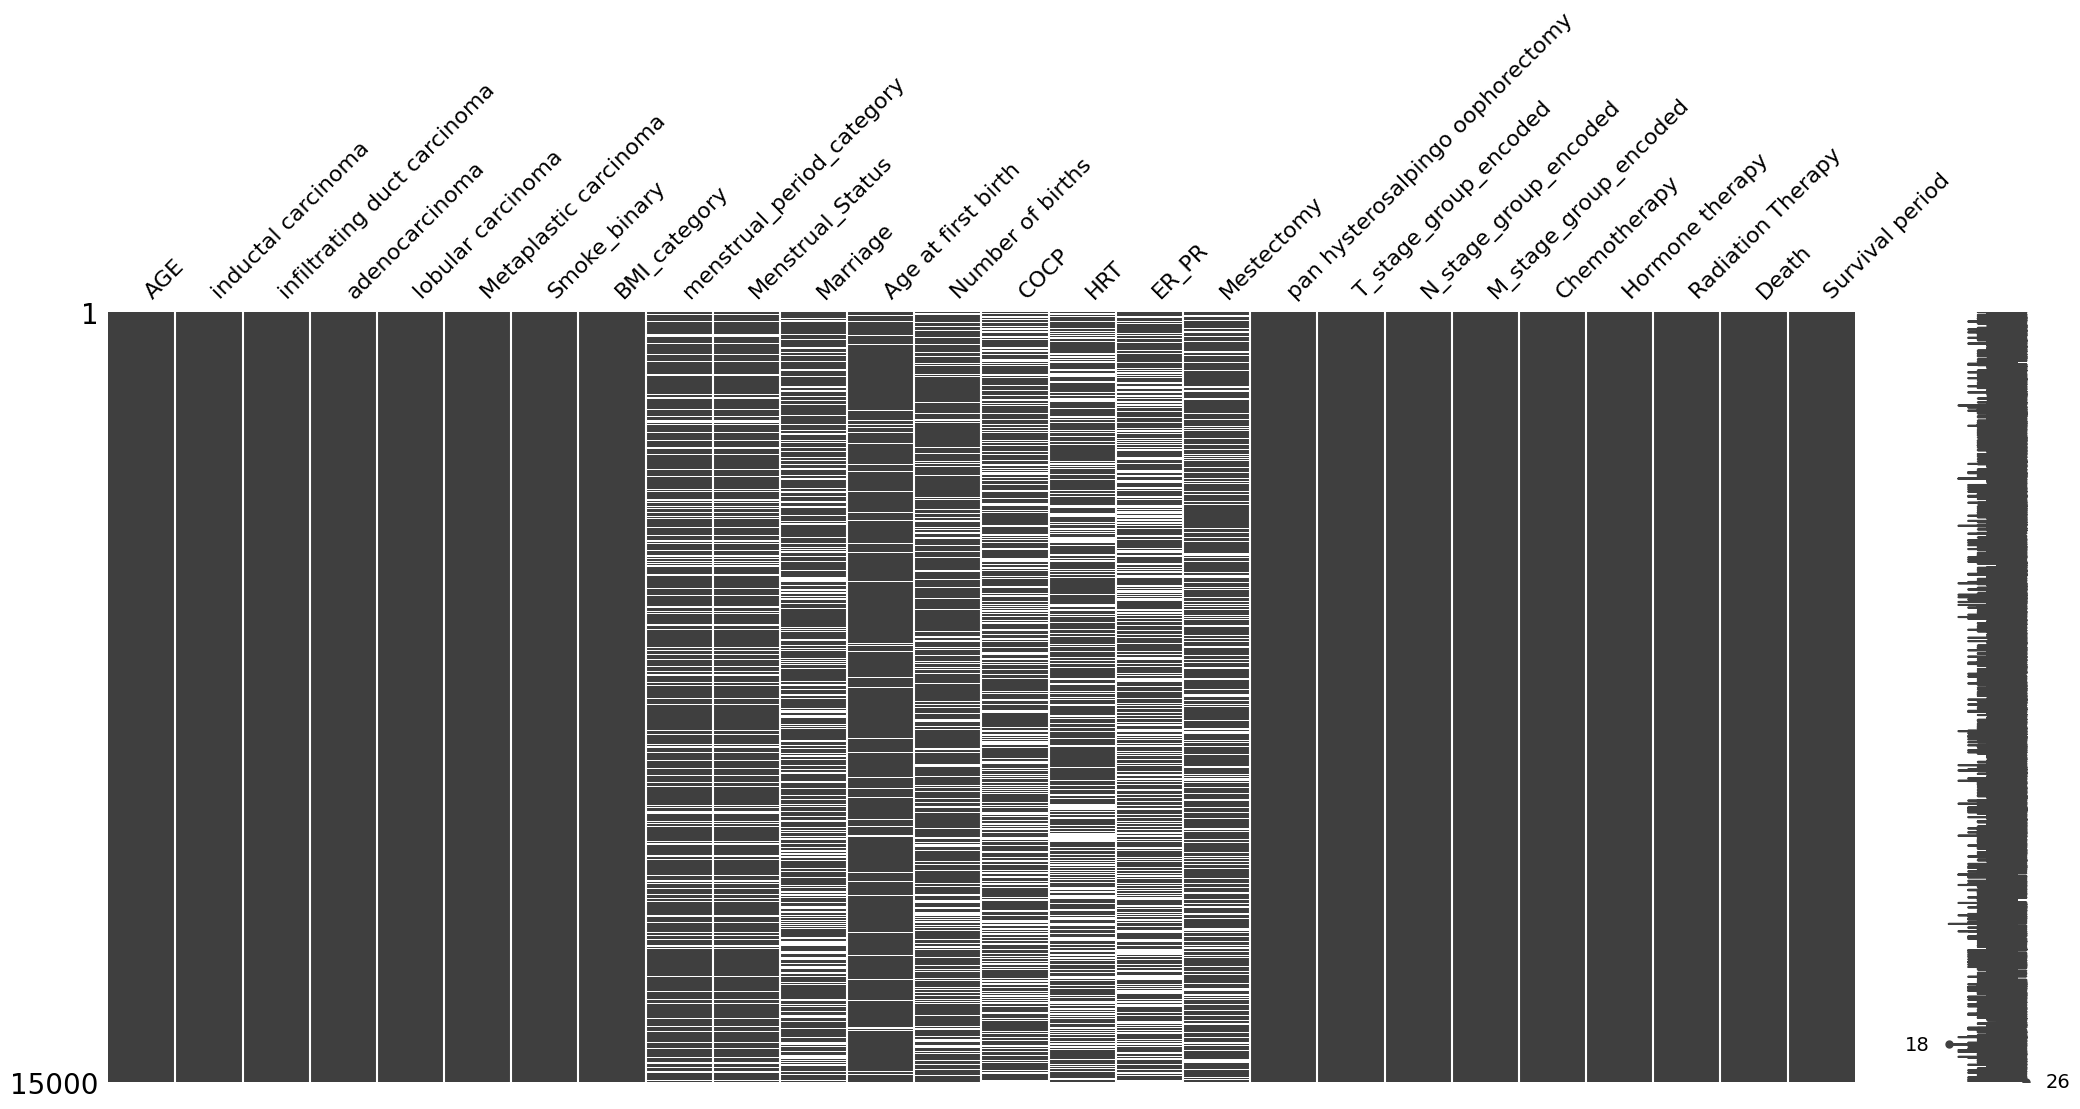

In [15]:
msno.matrix(synbreast.replace(99, np.nan))

In [16]:
def calculate_missing_ratio(df):
  """데이터프레임의 결측률 확인 (내림차순)"""
    
  missing_counts = df.isnull().sum()
  total_data_points = len(df)
  missing_ratios = (missing_counts / total_data_points) * 100
  return missing_ratios.sort_values(ascending=False)

calculate_missing_ratio(synbreast.replace(99, np.nan))


/var/folders/hv/3v5_v5l54x5085dq2488s5dr0000gn/T/ipykernel_46306/1624660198.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  calculate_missing_ratio(synbreast.replace(99, np.nan))


ER_PR                               36.380000
COCP                                31.920000
HRT                                 31.106667
Marriage                            27.513333
Mestectomy                          24.200000
Number of births                    19.780000
Menstrual_Status                    15.846667
menstrual_period_category           15.846667
Age at first birth                   5.860000
Chemotherapy                         0.000000
M_stage_group_encoded                0.000000
N_stage_group_encoded                0.000000
pan hysterosalpingo oophorectomy     0.000000
Hormone therapy                      0.000000
T_stage_group_encoded                0.000000
Radiation Therapy                    0.000000
Death                                0.000000
AGE                                  0.000000
inductal carcinoma                   0.000000
BMI_category                         0.000000
Smoke_binary                         0.000000
Metaplastic carcinoma             

In [17]:
# 결측치 전부 없앨경우 1554개만 남음

# 결측률 높은 거 제외 후 재생성
synbreast = synbreast.drop(columns=['ER_PR','COCP','HRT','Marriage','Number of births']).replace(99, np.nan).dropna()
len(synbreast)

/var/folders/hv/3v5_v5l54x5085dq2488s5dr0000gn/T/ipykernel_46306/256664740.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  synbreast = synbreast.drop(columns=['ER_PR','COCP','HRT','Marriage','Number of births']).replace(99, np.nan).dropna()


9025

In [18]:
for i in list(synbreast.drop(columns=['AGE','Age at first birth','Death']).columns):
    synbreast[i] = synbreast[i].astype('category')


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

Failed to import duecredit due to No module named 'duecredit'


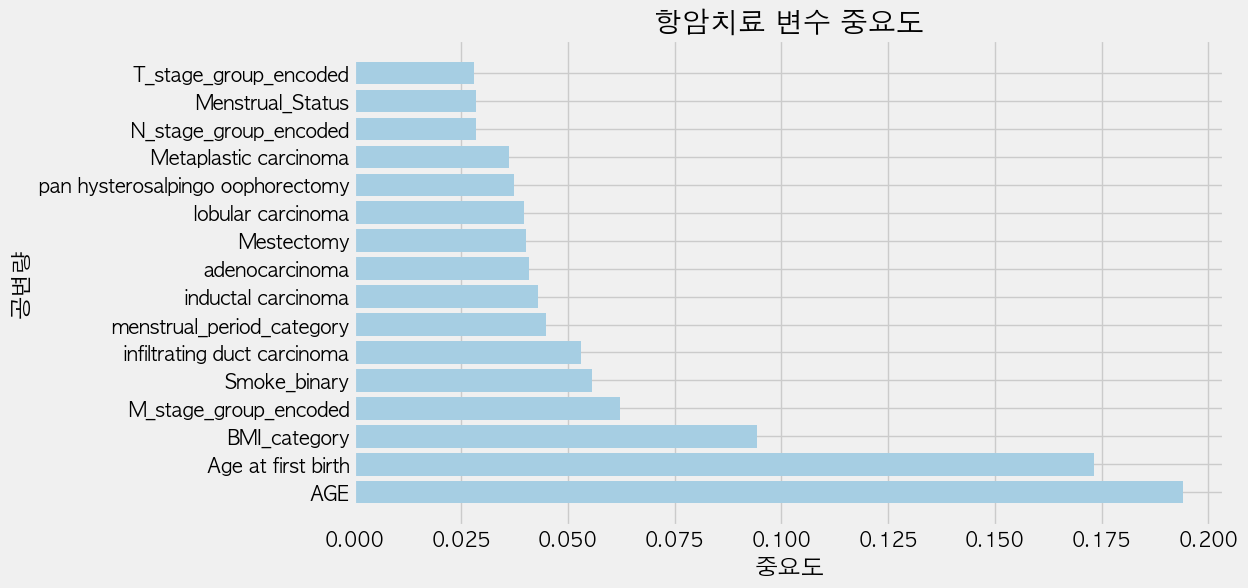

In [19]:
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')

X = synbreast.drop(columns=['Death','Survival period','Chemotherapy','Hormone therapy', 'Radiation Therapy'])
t = synbreast.Chemotherapy
y = synbreast.Death

model = UpliftRandomForestClassifier(control_name='0', max_depth=10, min_samples_leaf=10, n_estimators=100, random_state=42)
model.fit(X.values, t.astype(str).values, y.values)

feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('항암치료 변수 중요도')
plt.show()

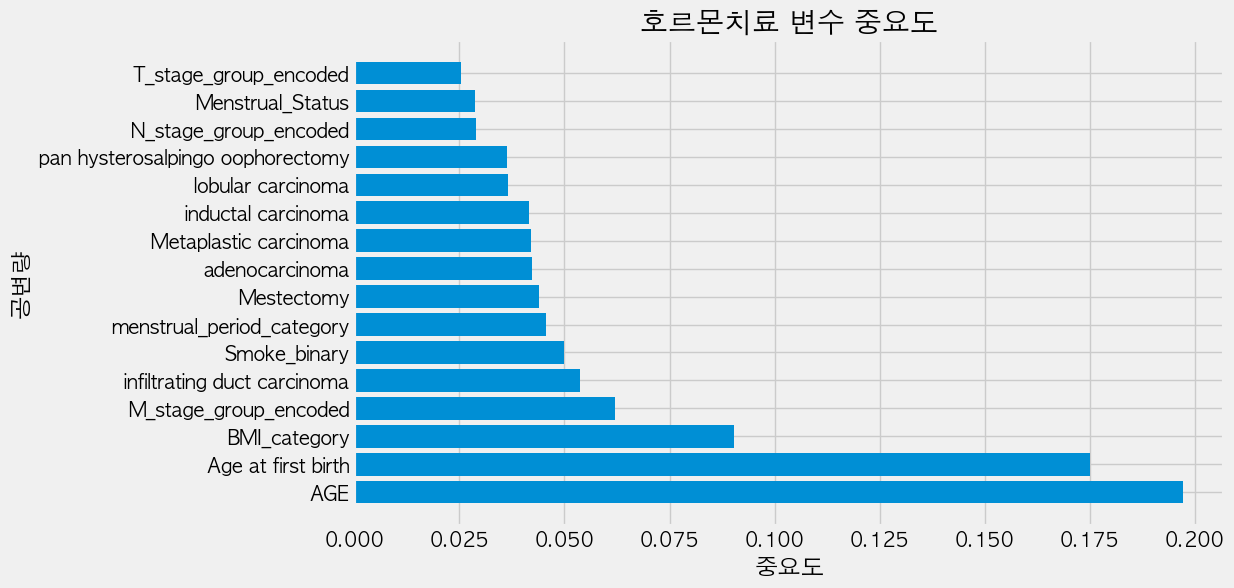

In [125]:
X = synbreast.drop(columns=['Death','Survival period','Chemotherapy','Hormone therapy', 'Radiation Therapy'])
t = synbreast['Hormone therapy']
y = synbreast.Death

model = UpliftRandomForestClassifier(control_name='0', max_depth=10, min_samples_leaf=10, n_estimators=100, random_state=42)
model.fit(X.values, t.astype(str).values, y.values)

feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('호르몬치료 변수 중요도')
plt.show()

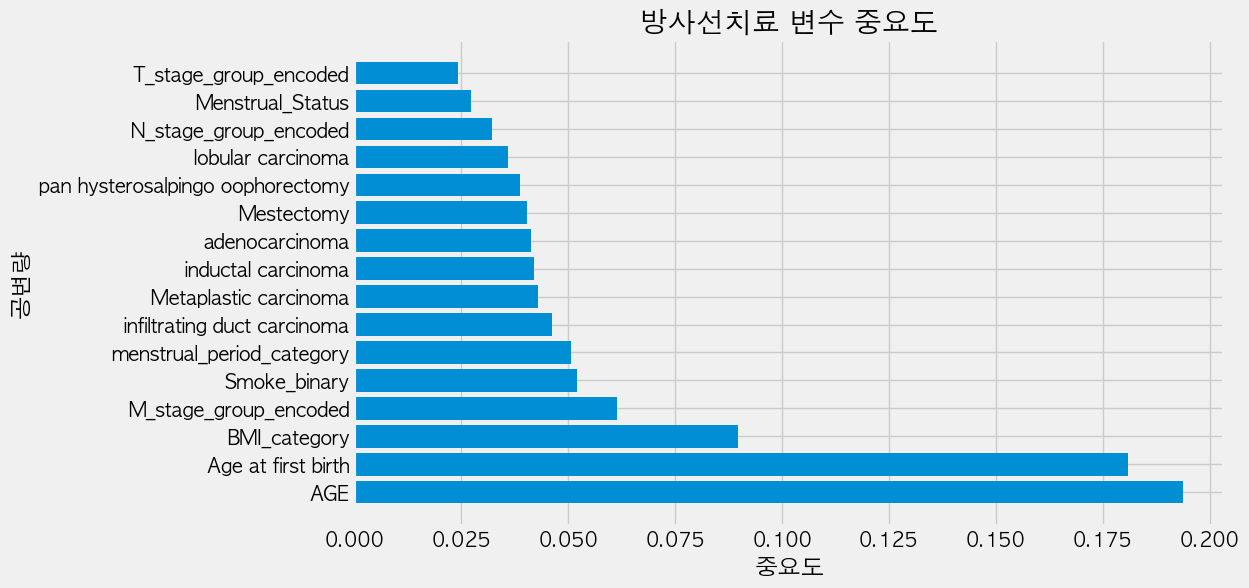

In [126]:
X = synbreast.drop(columns=['Death','Survival period','Chemotherapy','Hormone therapy', 'Radiation Therapy'])
t = synbreast['Radiation Therapy']
y = synbreast.Death

model = UpliftRandomForestClassifier(control_name='0', max_depth=10, min_samples_leaf=10, n_estimators=100, random_state=42)
model.fit(X.values, t.astype(str).values, y.values)

feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('방사선치료 변수 중요도')
plt.show()

# 4. EDA

# 5. 데이터 분석

## (선택1) 5. 치료 3가지(처치)를 하나로 합치기 

In [19]:
synbreast_ex2_all = synbreast.copy()

treatment_mapping = {
    (0,0,0): 0,   # 무처치
    (1,0,0): 1,   # 항암 단독
    (0,1,0): 2,   # 호르몬 단독
    (0,0,1): 3,   # 방사선 단독  
    (1,1,0): 4,   # 항암+호르몬
    (1,0,1): 5,   # 항암+방사선
    (0,1,1): 6,   # 호르몬+방사선
    (1,1,1): 7    # 삼중요법
}

commonness = list(synbreast_ex2_all.drop(columns=['Chemotherapy','Hormone therapy', 'Radiation Therapy', 'Death', 'Survival period']).columns)

synbreast_ex2_all['combo_tx'] = synbreast_ex2_all[['Chemotherapy','Hormone therapy','Radiation Therapy']]\
                  .apply(tuple, axis=1).map(treatment_mapping)
synbreast_ex2_all['combo_tx'].value_counts()

combo_tx
7    2072
5    1386
4    1347
6    1194
1     843
3     825
2     764
0     594
Name: count, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

X = synbreast_ex2_all[commonness]
y = synbreast_ex2_all.Death
T = synbreast_ex2_all['combo_tx']

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, T, test_size=0.3, random_state=24)


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

Failed to import duecredit due to No module named 'duecredit'


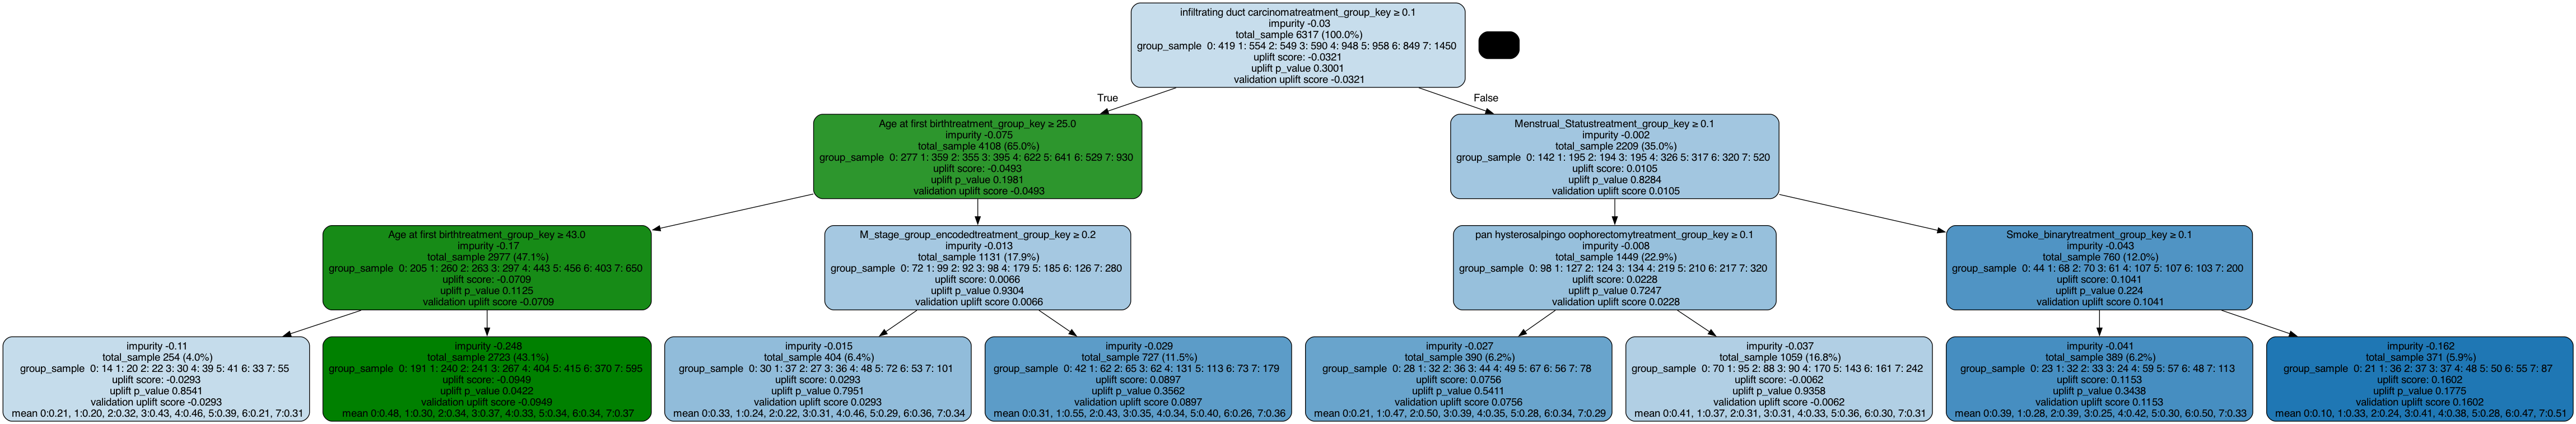

In [21]:
# 의사결정트리 활용

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini

from IPython.display import Image

uplift_model = UpliftTreeClassifier(max_depth = 4, control_name='0')

uplift_model.fit(X=X_train.values,
                 treatment=treatment_train.astype(str).values,
                 y=y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, synbreast_ex2_all[commonness].columns)
Image(graph.create_png())

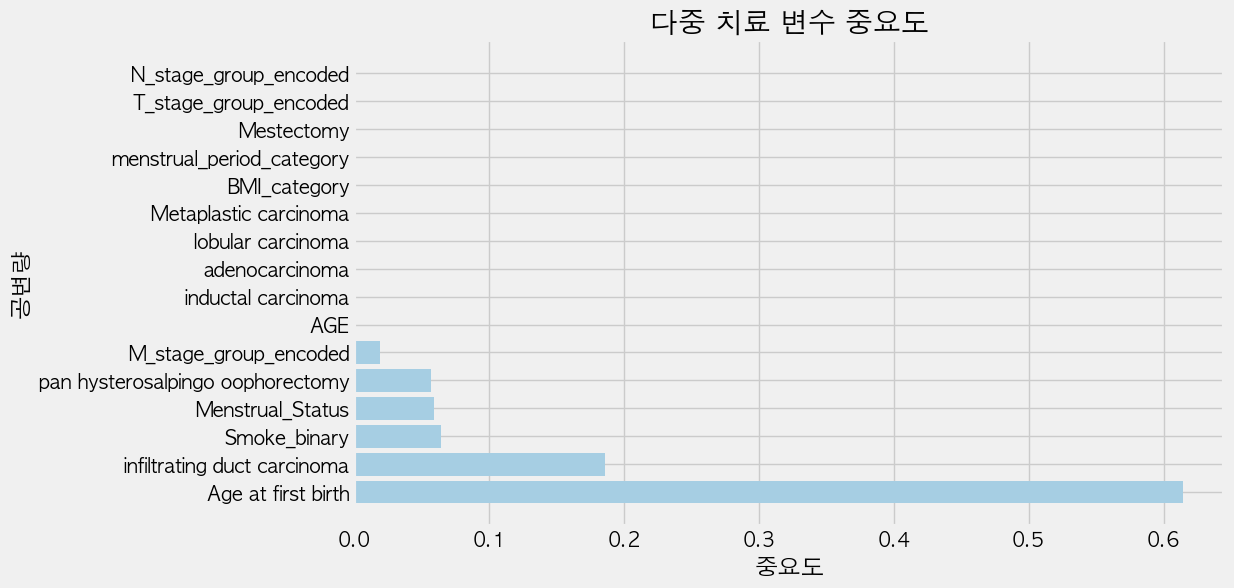

In [22]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

feature_importances = uplift_model.feature_importances_
feature_names = synbreast_ex2_all[commonness].columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('다중 치료 변수 중요도')
plt.show()

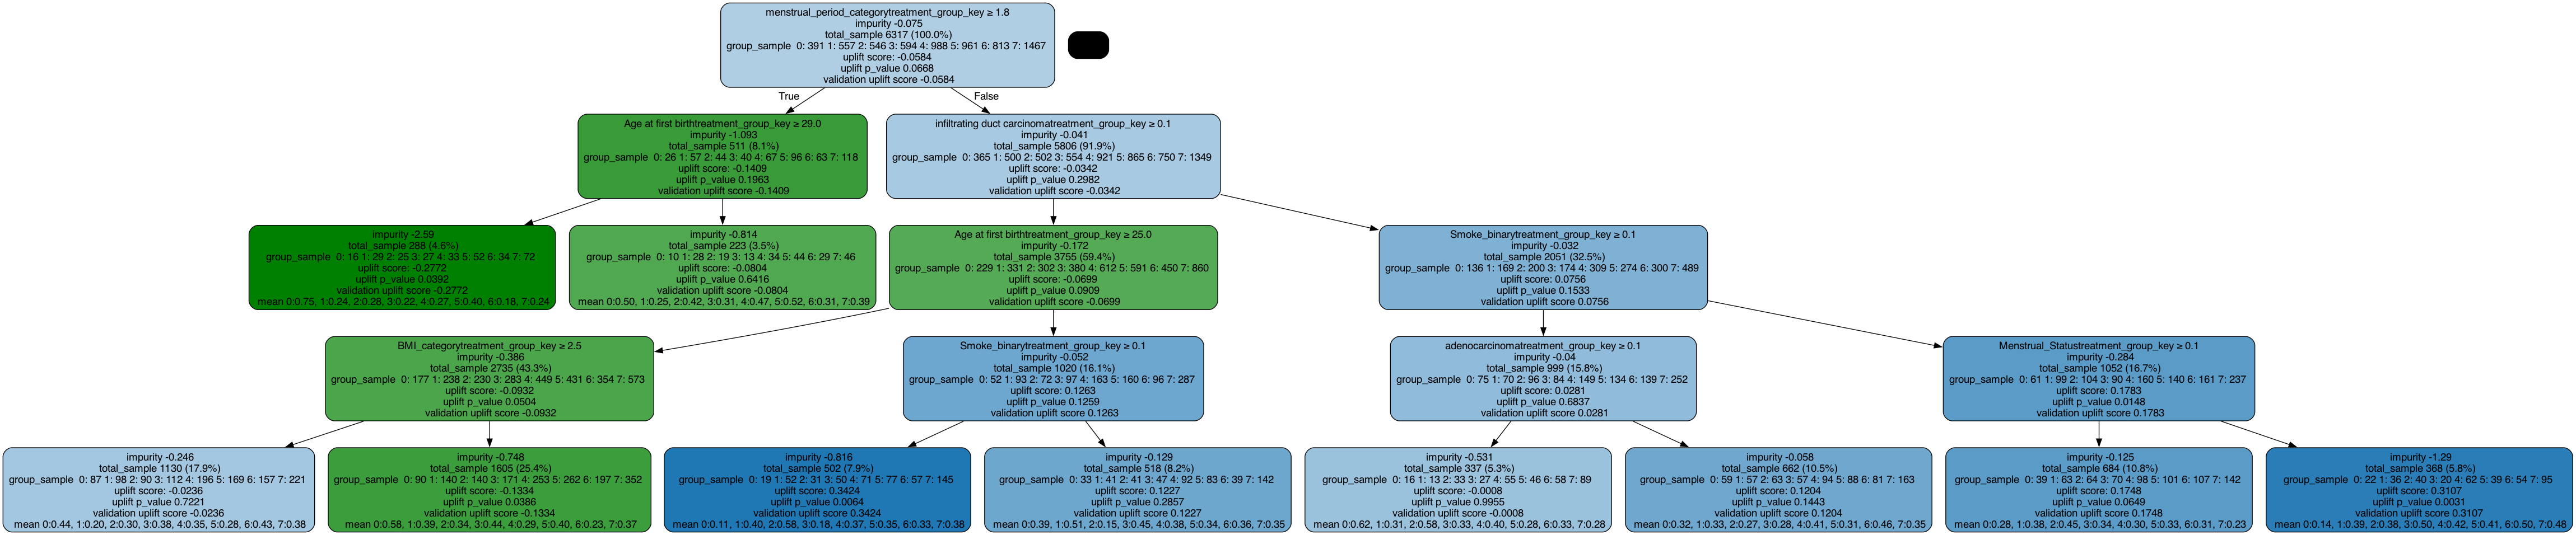

In [29]:
# 랜덤포레스트 활용

model = UpliftRandomForestClassifier(control_name='0', max_depth=5, random_state=42)
model.fit(X=X_train.values,
                 treatment=treatment_train.astype(str).values,
                 y=y_train.values)

graph = uplift_tree_plot(model.uplift_forest[0].fitted_uplift_tree, synbreast_ex2_all[commonness].columns)
Image(graph.create_png())

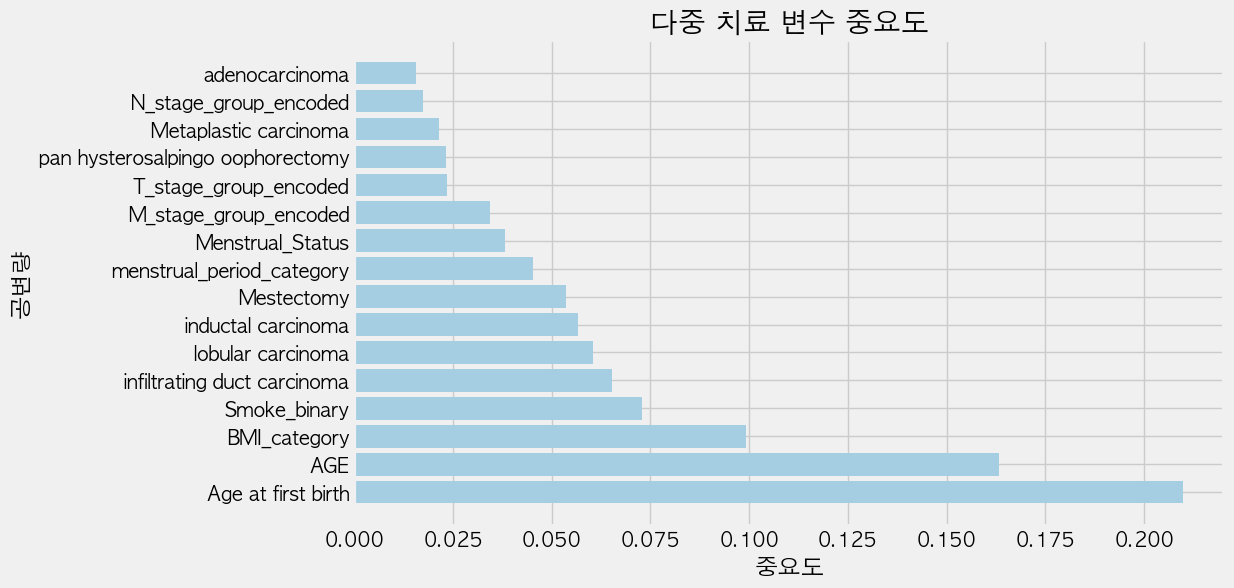

In [30]:
feature_importances = model.feature_importances_
feature_names = synbreast_ex2_all[commonness].columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('다중 치료 변수 중요도')
plt.show()

In [31]:
y_pred = model.predict(X_test)

uplift_results = pd.DataFrame(y_pred, columns=model.classes_[1:])
best_treatment = np.where(uplift_results['1'] < 0, 0, 1)

auuc_metrics = (uplift_results.assign(is_treated=(treatment_test.values != 1).astype(int),
                              conversion=pd.concat([X_test, y_test, treatment_test], axis=1)['Death'].values,
                              uplift=uplift_results.max(axis=1))
                .drop(columns=list(model.classes_[1:])))

# Print AUUC metrics DataFrame
print("AUUC metrics DataFrame:")
display(auuc_metrics)

AUUC metrics DataFrame:


,is_treated,conversion,uplift
0,1,0,-0.061571
1,1,0,0.009633
2,1,0,0.057344
3,1,0,-0.034820
4,1,0,0.149126
...,...,...,...
2703,1,1,-0.106313
2704,1,1,0.012229
2705,1,1,-0.006205
2706,1,0,-0.091182


uplift   -0.56344
dtype: float64


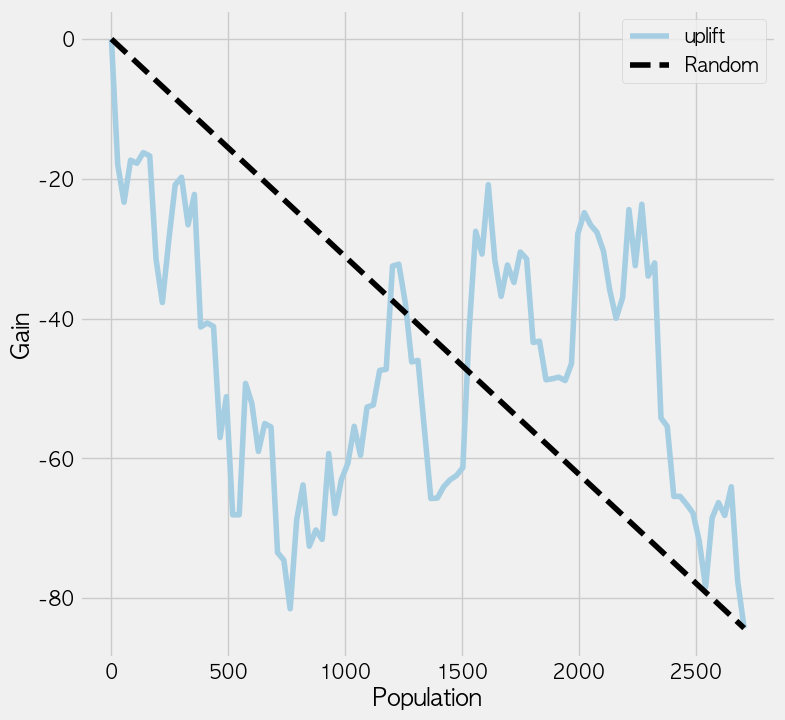

In [32]:
# Plot the uplift curve (AUUC: area under uplift curve)
from causalml.metrics import auuc_score, qini_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

plt.rcParams['axes.unicode_minus'] = False
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

## (선택2) 5. 치료여부에 따른 처치 나누기 
- (치료여부 -> 사망) 으로 인과관계를 따질것으로 보여짐
- 공통 공변량을 선정하고, 각 치료여부에 따른 특화된 변수로 선정하는 방향으로 (그냥 공통으로 전부 같게 할지 아직 고민중)

In [45]:
treatment_mapping = {
    (0,0,0): 0,   # 무처치
    (1,0,0): 1,   # 항암 단독
    (0,1,0): 2,   # 호르몬 단독
    (0,0,1): 3,   # 방사선 단독  
    (1,1,0): 4,   # 항암+호르몬
    (1,0,1): 5,   # 항암+방사선
    (0,1,1): 6,   # 호르몬+방사선
    (1,1,1): 7    # 삼중요법
}


# 공통 공변량 선정
# commonness = ['AGE','diagnosis_group_encoded','T_stage_group_encoded','N_stage_group_encoded','M_stage_group_encoded']

### 5-1. 항암치료

In [46]:
synbreast_ex1 = synbreast.copy()
synbreast_ex1['combo_tx'] = synbreast_ex1[['Chemotherapy','Hormone therapy','Radiation Therapy']]\
                  .apply(tuple, axis=1).map(treatment_mapping)
synbreast_ex1=synbreast_ex1[(synbreast_ex1['combo_tx'] == 0)|(synbreast_ex1['combo_tx'] == 1)]
synbreast_ex1.reset_index(inplace=True, drop=True)
Chemotherapy_all_v = list(synbreast_ex1.drop(columns=['Chemotherapy','Hormone therapy', 'Radiation Therapy', 'Death', 'Survival period','combo_tx']).columns)

C_t = synbreast_ex1.Chemotherapy # 처치 (항암치료)
C_y = synbreast_ex1.Death # 결과
C_X = synbreast_ex1[Chemotherapy_all_v] # 공변량

In [47]:
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(C_X, C_y, C_t, test_size=0.3, random_state=24)

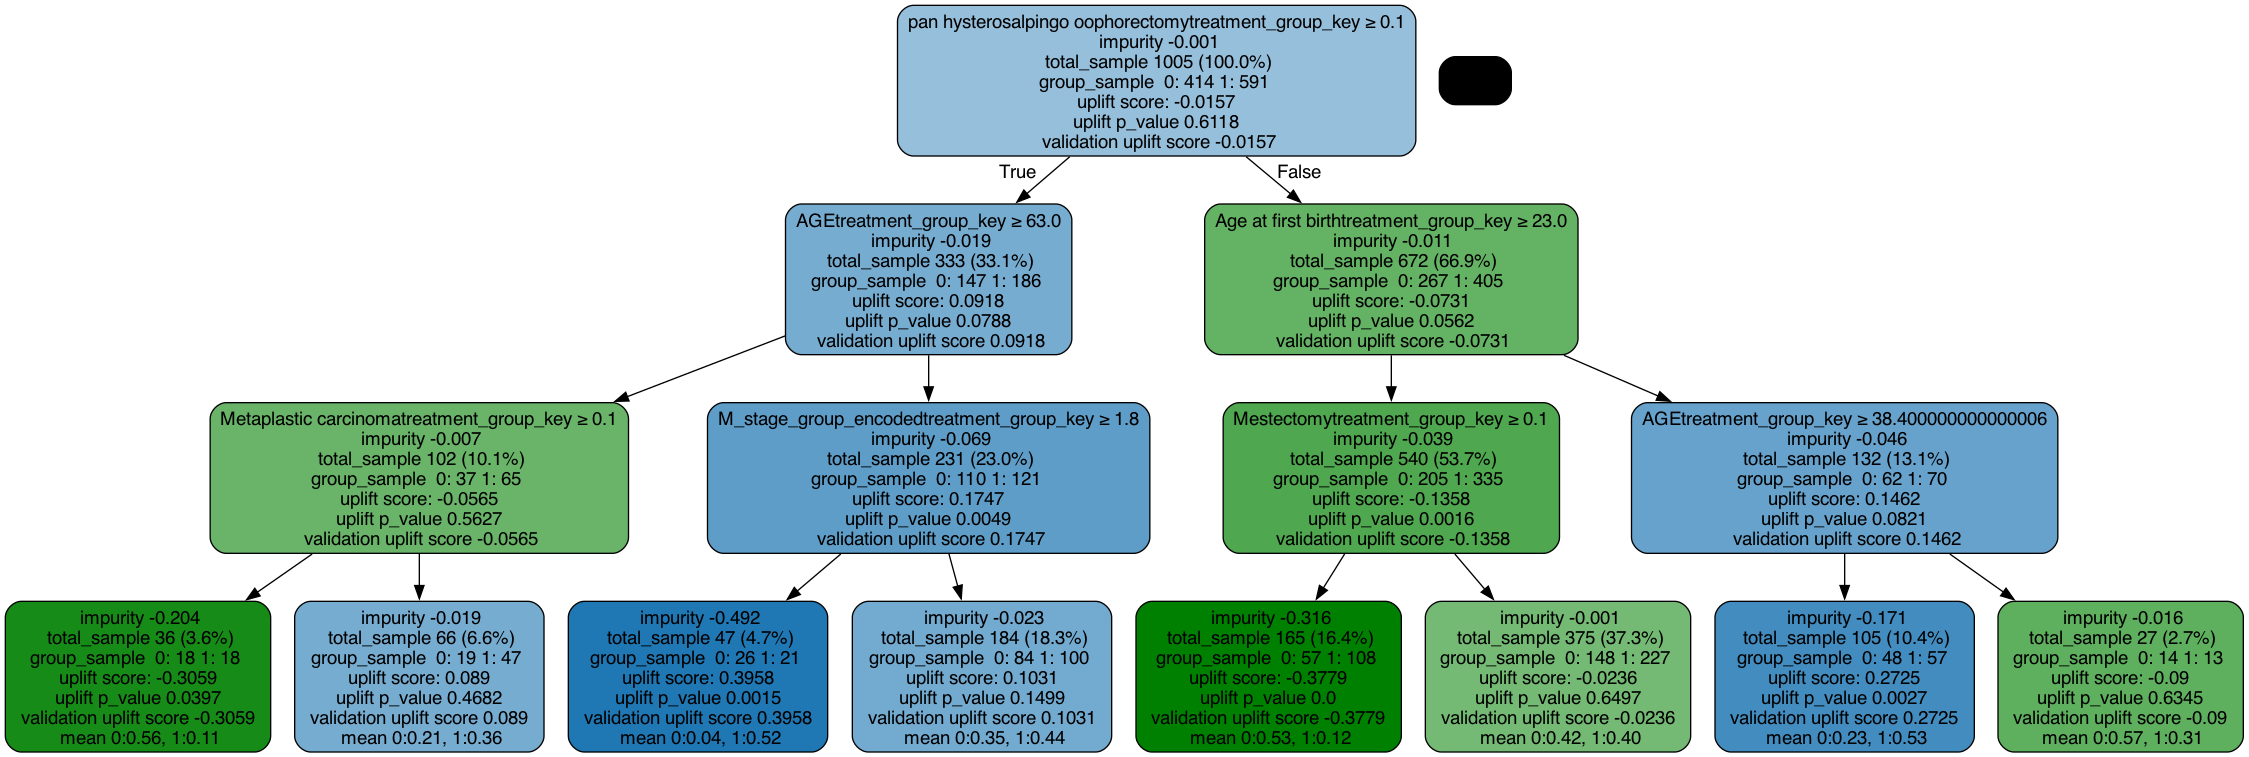

In [52]:
# 랜덤포레스트 활용
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini

from IPython.display import Image

model = UpliftRandomForestClassifier(control_name='0', max_depth=4, min_samples_leaf=10, n_estimators=100, random_state=42)
model.fit(X=X_train.values,
                 treatment=treatment_train.astype(str).values,
                 y=y_train.values)

graph = uplift_tree_plot(model.uplift_forest[0].fitted_uplift_tree, C_X.columns)
Image(graph.create_png())

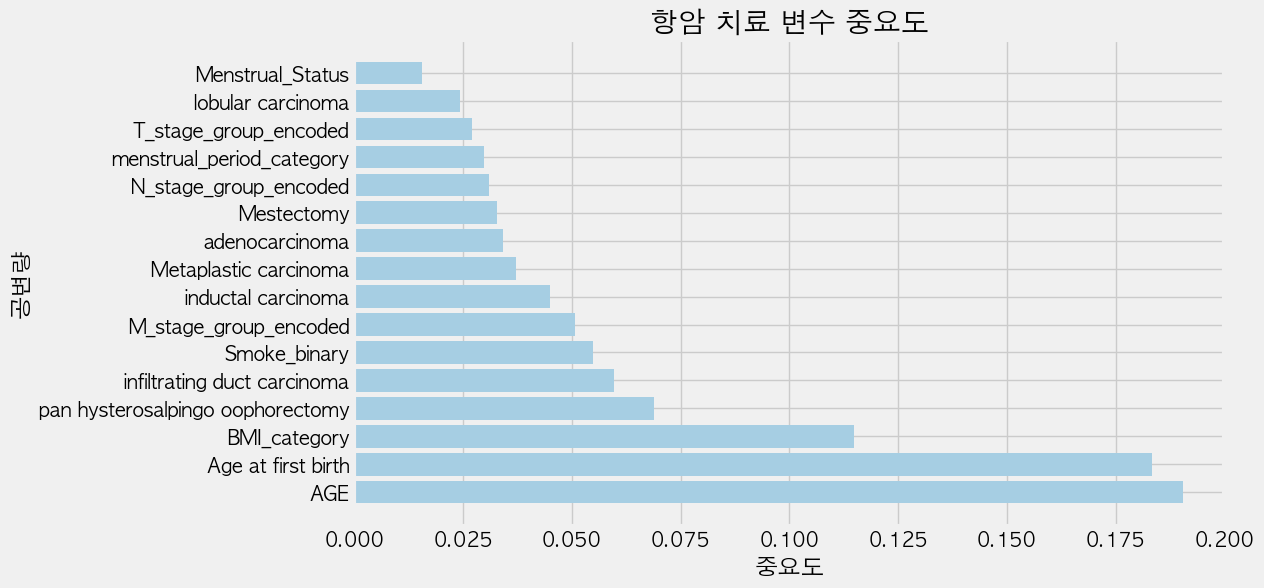

In [53]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

feature_importances = model.feature_importances_
feature_names = C_X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('항암 치료 변수 중요도')
plt.show()

In [54]:
y_pred = model.predict(X_test)

uplift_results = pd.DataFrame(y_pred, columns=model.classes_[1:])
best_treatment = np.where(uplift_results['1'] < 0, 0, 1)

auuc_metrics = (uplift_results.assign(is_treated=(treatment_test.values != 1).astype(int),
                              conversion=pd.concat([X_test, y_test, treatment_test], axis=1)['Death'].values,
                              uplift=uplift_results.max(axis=1))
                .drop(columns=list(model.classes_[1:])))

# Print AUUC metrics DataFrame
print("AUUC metrics DataFrame:")
display(auuc_metrics)

AUUC metrics DataFrame:


,is_treated,conversion,uplift
0,1,1,-0.176044
1,1,1,-0.007746
2,0,0,-0.001237
3,0,1,0.056835
4,1,1,-0.049925
...,...,...,...
427,0,0,-0.061702
428,0,0,-0.023648
429,0,1,-0.048047
430,0,0,-0.018286


In [55]:
from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

uplift    0.532079
dtype: float64


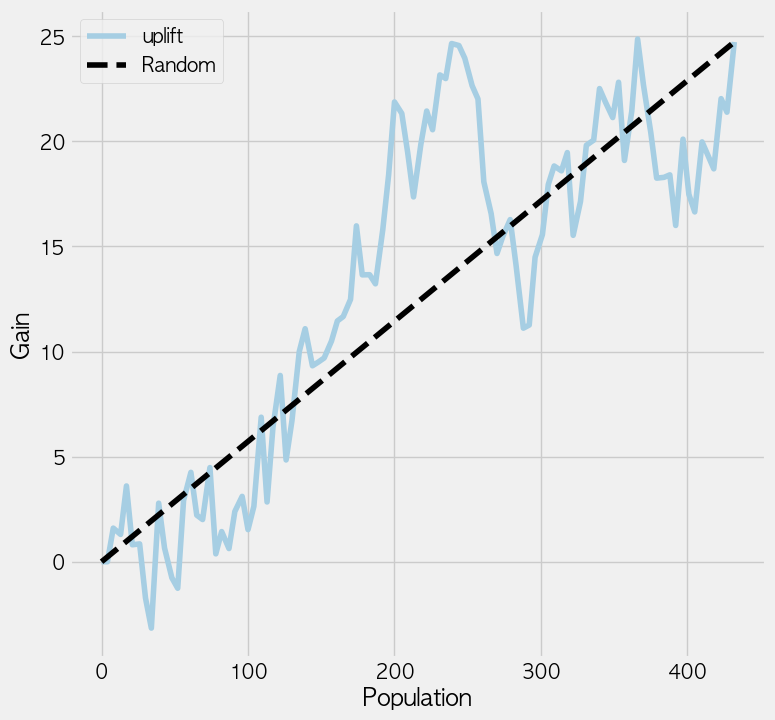

In [56]:
# Plot the uplift curve (AUUC: area under uplift curve)
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


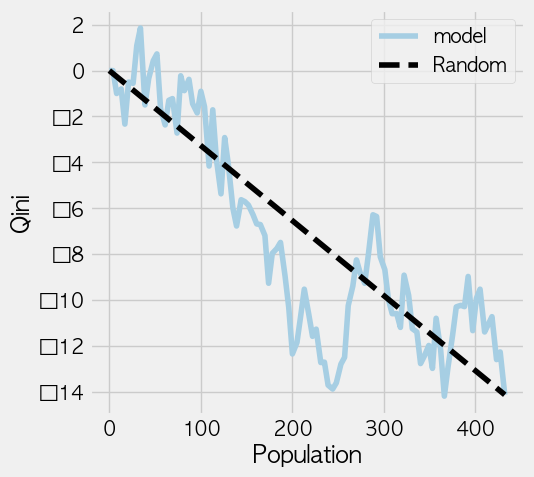

In [57]:
from causalml.metrics import plot_qini

df_result = pd.DataFrame({
    'Death': y_test.squeeze(),
    'is_treated': treatment_test.squeeze(),
    'model': y_pred.squeeze()
})
df_result['is_treated'] = df_result['is_treated'].astype(int)


plot_qini(df_result,
          outcome_col='Death',
          treatment_col='is_treated',
          figsize=(5,5)
         )

In [41]:
# 1. ATE (Average Treatment Effect) 추정 - 단순 비교
treated_outcome_mean = C_y[(C_t == 1)].mean()
untreated_outcome_mean = C_y[(C_t == 0)].mean()
ate_simple_difference = treated_outcome_mean - untreated_outcome_mean

print(f"단순 비교를 통해 - 항암 치료를 받은 그룹의 생존률이 항암 치료를 받지 않은 그룹의 생존률보다 약: {ate_simple_difference*-100:.2f}% 더 높다.")

단순 비교를 통해 - 항암 치료를 받은 그룹의 생존률이 항암 치료를 받지 않은 그룹의 생존률보다 약: 2.76% 더 높다.


<Axes: xlabel='N_stage_group_encoded'>

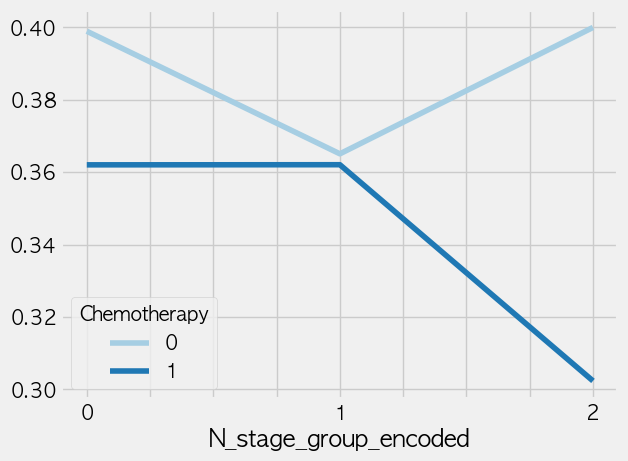

In [43]:
a = synbreast_ex1.query('AGE <= 70')
pd.crosstab(index=a.N_stage_group_encoded, columns=a.Chemotherapy, values=a.Death, aggfunc='mean').plot()

In [45]:
pd.crosstab(index=synbreast_ex1.Chemotherapy, columns=synbreast_ex1.T_stage_group_encoded, values=synbreast_ex1.Death, aggfunc='mean')

T_stage_group_encoded,0,1,2,3
Chemotherapy,,,,
0,0.398390,0.346667,0.333333,0.428571
1,0.364512,0.376471,0.333333,0.200000


### 5-2. 호르몬치료

In [64]:
synbreast_ex2 = synbreast.copy()
synbreast_ex2['combo_tx'] = synbreast_ex2[['Chemotherapy','Hormone therapy','Radiation Therapy']]\
                  .apply(tuple, axis=1).map(treatment_mapping)
synbreast_ex2=synbreast_ex2[(synbreast_ex2['combo_tx'] == 0)|(synbreast_ex2['combo_tx'] == 2)]

Hormone_all_v = commonness + ['COCP', 'HRT','ER', 'PR', 'AR','BRCA1 PVs','BRCA1 VUS', 'BRCA2 PVs', 'BRCA2 VUS']

H_t = synbreast_ex2['Hormone therapy'] # 처치 (호르몬치료)
H_y = synbreast_ex2.Death # 결과
H_X = synbreast_ex2[Hormone_all_v] # 공변량

In [65]:
# 1. ATE (Average Treatment Effect) 추정 - 단순 비교
treated_outcome_mean = H_y[H_t == 1].mean()
untreated_outcome_mean = H_y[H_t == 0].mean()
ate_simple_difference = treated_outcome_mean - untreated_outcome_mean
 
print(f"단순 비교를 통해 - 호르몬 치료를 받은 그룹의 사망률이 호르몬 치료를 받지 않은 그룹의 사망률보다 약: {ate_simple_difference*100:.2f}% 더 높다.")


단순 비교를 통해 - 호르몬 치료를 받은 그룹의 사망률이 호르몬 치료를 받지 않은 그룹의 사망률보다 약: -3.53% 더 높다.


In [66]:
synbreast_ex2.Death.value_counts()

Death
0    1432
1     815
Name: count, dtype: int64

In [57]:
pd.pivot_table(data=synbreast_ex2, index='diagnosis_group_encoded',columns='Hormone therapy', values='Death')

Hormone therapy,0,1
diagnosis_group_encoded,,
0,0.390244,0.408163
1,0.343750,0.352941
2,0.370079,0.347826
3,0.400943,0.351064
4,0.372549,0.254237


### 5-3. 방사선치료

In [67]:
synbreast_ex3 = synbreast.copy()
synbreast_ex3['combo_tx'] = synbreast_ex3[['Chemotherapy','Hormone therapy','Radiation Therapy']]\
                  .apply(tuple, axis=1).map(treatment_mapping)
synbreast_ex3=synbreast_ex3[(synbreast_ex2['combo_tx'] == 0)|(synbreast_ex2['combo_tx'] == 3)]

Radiation_all_v = commonness + ['BCS', 'Mestectomy', 'pan hysterosalpingo oophorectomy']

R_t = synbreast_ex3['Radiation Therapy'] # 처치 (방사선치료)
R_y = synbreast_ex3.Death # 결과
R_X = synbreast_ex3[Radiation_all_v] # 공변량

In [68]:
# 1. ATE (Average Treatment Effect) 추정 - 단순 비교
treated_outcome_mean = R_y[R_t == 1].mean()
untreated_outcome_mean = R_y[R_t == 0].mean()
ate_simple_difference = treated_outcome_mean - untreated_outcome_mean
 
print(f"단순 비교를 통해 - 방사선 치료를 받은 그룹의 사망률이 방사선 치료를 받지 않은 그룹의 사망률보다 약: {ate_simple_difference*100:.2f}% 더 높다.")

단순 비교를 통해 - 방사선 치료를 받은 그룹의 사망률이 방사선 치료를 받지 않은 그룹의 사망률보다 약: -3.44% 더 높다.


In [69]:
synbreast_ex3.Death.value_counts()

Death
0    1464
1     834
Name: count, dtype: int64

In [48]:
pd.pivot_table(data=synbreast_ex3, index='diagnosis_group_encoded',columns='Radiation Therapy', values='Death')

Radiation Therapy,0,1
diagnosis_group_encoded,,
0,0.390244,0.350000
1,0.343750,0.280374
2,0.370079,0.364991
3,0.400943,0.359107
4,0.372549,0.239437
